### **- Metodo Secuencial**

**1. Inicializa la matriz**

In [ ]:
from IPython.display import clear_output
from concurrent.futures import ThreadPoolExecutor
import numpy as np
import time

tamañoMatriz = 10
matriz = np.random.randint(0, 2, (tamañoMatriz, tamañoMatriz))

print(matriz)

[[1 1 1 0 1 0 0 1 1 1]
 [0 1 0 1 0 1 1 1 1 0]
 [0 0 1 1 0 0 0 0 0 1]
 [1 0 0 1 0 0 1 1 0 1]
 [1 0 0 0 0 1 0 1 0 0]
 [0 1 1 0 1 0 0 1 0 0]
 [1 0 0 1 1 1 1 1 0 1]
 [0 0 1 1 1 1 0 0 0 0]
 [1 1 0 1 1 0 0 1 0 0]
 [1 1 1 0 0 0 0 1 1 1]]


**2. Calcula la cantidad de celulas vivas**


In [ ]:
def sumarVecinosVivos(matriz, x, y):
    filas, columnas = len(matriz), len(matriz[0])
    vecinosVivos = 0

    for posX in [-1, 0, 1]:
        for posY in [-1, 0, 1]:
            if posX == 0 and posY == 0:
                continue
            celdaVecinaX, celdaVecinaY = x + posX, y + posY
            if 0 <= celdaVecinaX < filas and 0 <= celdaVecinaY < columnas:
                vecinosVivos += matriz[celdaVecinaX][celdaVecinaY]

    return vecinosVivos

In [ ]:
print(sumarVecinosVivos(matriz, 1, 8))

5


**3. Aplica las reglas del juego a la matriz**

In [ ]:
def generarNuevaMatriz(matriz):
    filas, columnas = len(matriz), len(matriz[0])
    nuevaMatriz = matriz.copy()

    for x in range(filas):
        for y in range(columnas):
            total = sumarVecinosVivos(matriz, x, y)
            if matriz[x][y] == 1 and (total < 2 or total > 3):
                nuevaMatriz[x][y] = 0  # Muere por soledad o sobrepoblación
            elif matriz[x][y] == 0 and total == 3:
                nuevaMatriz[x][y] = 1  # Nace una nueva célula

    return nuevaMatriz

print(generarNuevaMatriz(matriz))

[[1 1 1 1 1 1 0 0 0 1]
 [1 0 0 0 0 1 1 0 0 0]
 [0 1 0 1 0 1 0 0 0 1]
 [0 1 1 1 1 0 1 1 0 0]
 [1 0 1 1 1 1 0 1 0 0]
 [1 1 1 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 1 0]
 [1 0 0 0 0 0 0 1 1 0]
 [1 0 0 0 0 1 1 1 0 0]
 [1 0 1 1 0 0 0 1 1 0]]


**4. Simula la evolucion del juego**

In [ ]:
def ejecutarNumeros(matriz):
    tiempoInicio = time.time()
    generaciones = 0
    while True:
        clear_output(wait=True)
        nuevaMatriz = generarNuevaMatriz(matriz)
        print(nuevaMatriz)

        if np.array_equal(nuevaMatriz, matriz):
            print(f"El juego terminó en {generaciones} generaciones.")
            tiempoFinal = time.time()
            tiempoTranscurrido = tiempoFinal - tiempoInicio
            print(f"Tiempo transcurrido: {tiempoTranscurrido} segundos")
            break

        matriz = nuevaMatriz
        generaciones += 1

        if generaciones >= 100:
            print("Luego de 100 generaciones no ha terminado.")
            tiempoFinal = time.time()
            tiempoTranscurrido = tiempoFinal - tiempoInicio
            print(f"Tiempo transcurrido: {tiempoTranscurrido} segundos")
            break

### **- Metodo Paralelo**

**1. Divide la matriz y aplica las reglas del juego.**

In [ ]:
def procesarBloque(matriz, inicioFila, finFila):
    """Procesa una porción de la matriz para calcular la siguiente generación."""
    filas, columnas = matriz.shape
    nuevaSubmatriz = np.copy(matriz[inicioFila:finFila])

    for fila in range(inicioFila, finFila):
        for columna in range(columnas):
            totalVecinos = sumarVecinosVivos(matriz, fila, columna)
            if matriz[fila][columna] == 1 and (totalVecinos < 2 or totalVecinos > 3):
                nuevaSubmatriz[fila - inicioFila][columna] = 0  # Muere
            elif matriz[fila][columna] == 0 and totalVecinos == 3:
                nuevaSubmatriz[fila - inicioFila][columna] = 1  # Nace

    return inicioFila, nuevaSubmatriz

**2. Divide y asigna las tareas**

In [ ]:
def generarNuevaMatrizParalela(matriz, numHilos=4):
    filas = len(matriz)
    paso = filas // numHilos
    resultados = []

    with ThreadPoolExecutor(max_workers=numHilos) as executor:
        futures = []
        for i in range(numHilos):
            inicioFila = i * paso
            finFila = (i + 1) * paso if i != numHilos - 1 else filas
            futures.append(executor.submit(procesarBloque, np.copy(matriz), inicioFila, finFila))

        for future in futures:
            resultados.append(future.result())

    def ordenarPorIndice(tupla):
        return tupla[0]

    resultados.sort(key=ordenarPorIndice)
    nuevaMatriz = np.copy(matriz)
    for inicioFila, seccion in resultados:
        nuevaMatriz[inicioFila:inicioFila + seccion.shape[0]] = seccion

    return nuevaMatriz

**3. Simula la evolucion de las generaciones.**

In [ ]:
def ejecutarNumerosParalelo(matriz, numHilos=4):
    tiempoInicio = time.time()
    generaciones = 0

    while True:
        clear_output(wait=True)
        print(matriz)
        nuevaMatriz = generarNuevaMatrizParalela(matriz, numHilos)

        if np.array_equal(nuevaMatriz, matriz):
            print(f"El juego terminó en {generaciones} generaciones.")
            break

        matriz = np.copy(nuevaMatriz)  # Asegurar que la actualización sea completa
        generaciones += 1

        if generaciones >= 100:
            print("Luego de 100 generaciones no ha terminado.")
            break

    tiempoFinal = time.time()
    print(f"Tiempo transcurrido: {tiempoFinal - tiempoInicio} segundos")

### **Resultados**

In [ ]:
matrizSecuencial = ejecutarNumeros(matriz) #Unos y Ceros

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
El juego terminó en 20 generaciones.
Tiempo transcurrido: 0.06675291061401367 segundos


In [ ]:
matrizParalela = ejecutarNumerosParalelo(matriz) #Unos y Ceros

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
El juego terminó en 20 generaciones.
Tiempo transcurrido: 0.07952404022216797 segundos


**- Compara si las matrices dadas por los dos metodos sean iguales**

In [ ]:
# Comparar si son iguales
if np.array_equal(matrizSecuencial, matrizParalela):
    print("Las matrices resultantes son IGUALES.")
else:
    print("Las matrices resultantes son DIFERENTES.")

Las matrices resultantes son IGUALES.


### **Analisis de Resultados**

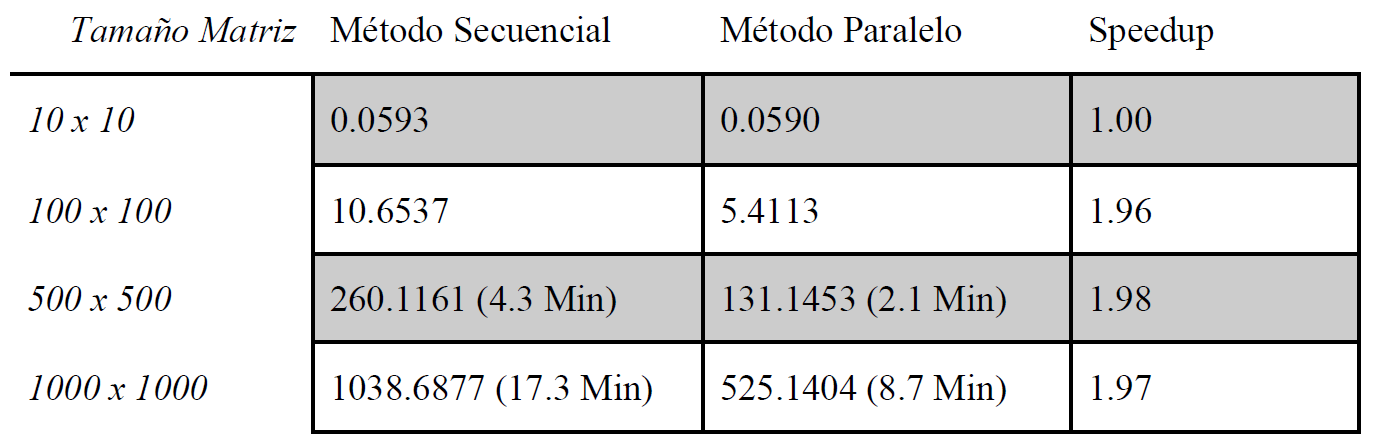

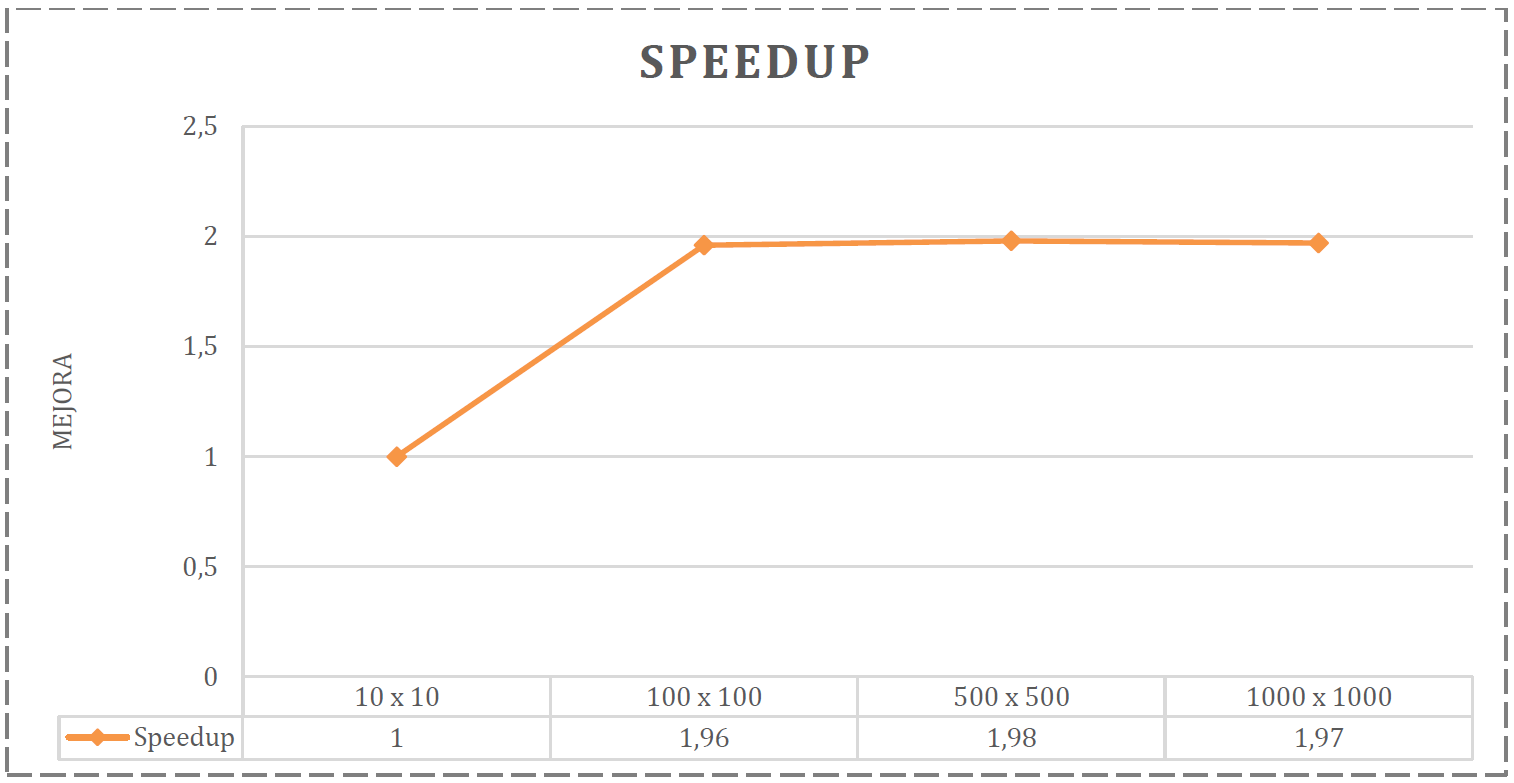

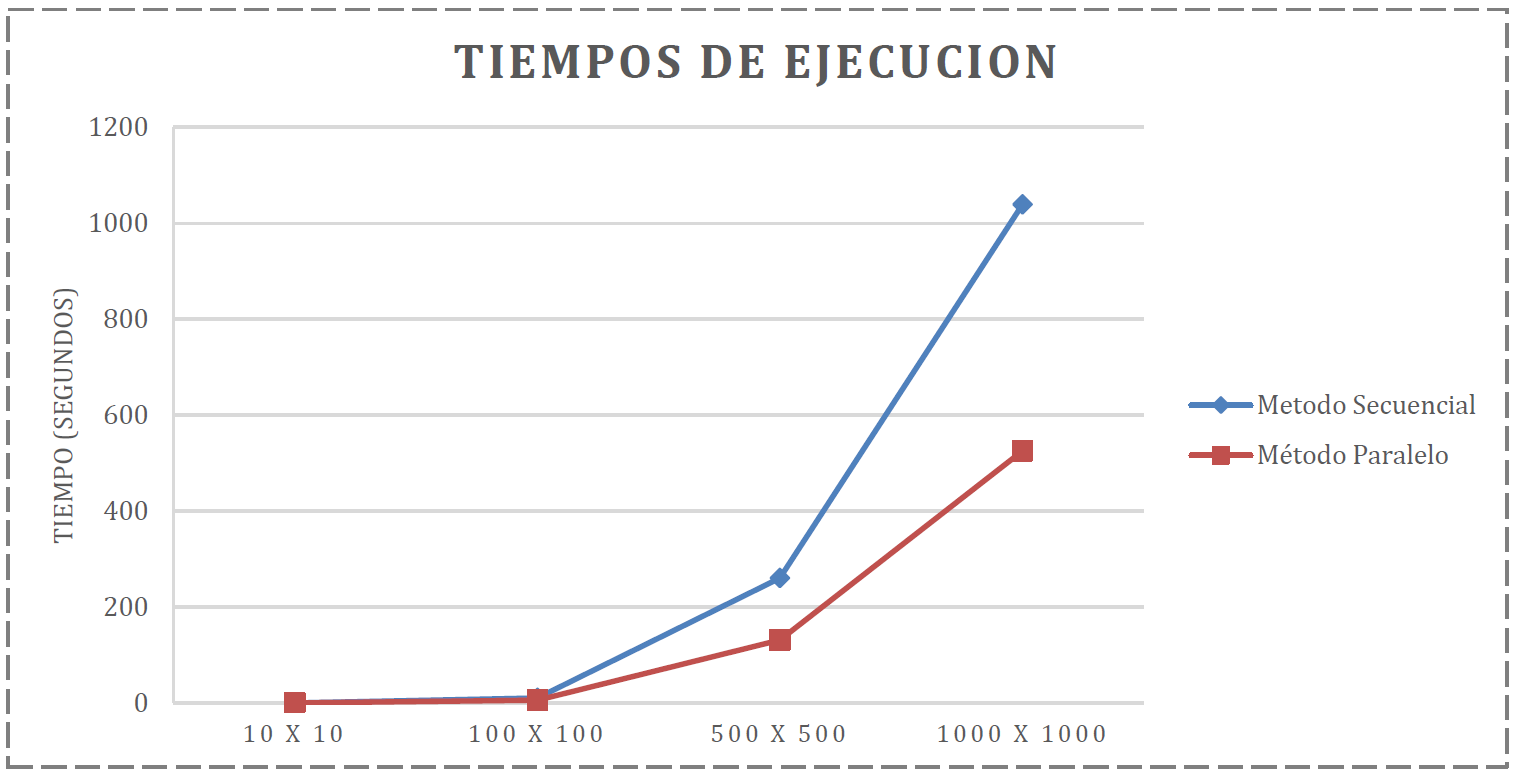